# 2018 World Cup review
In this Google Colab notebook, we will develop the Feature Selection for the Worldcup 2018 dataset. 

## 0. Data Loading

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks
import pandas as pd
from google.colab import files
from sklearn import preprocessing 
from sklearn.decomposition import PCA
import plotly.express as px
from scipy import cluster
import sklearn.neighbors
import seaborn as sns; sns.set()
import plotly.express as px

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving worldcup_2018_final_data.csv to worldcup_2018_final_data.csv
User uploaded file "worldcup_2018_final_data.csv" with length 11871 bytes


Once the file has been uploaded, load the data in RAM memory for a quicker access.

In [ ]:
df = pd.read_csv('/content/worldcup_2018_final_data.csv')
df.head()

,Unnamed: 0,team_name,team_round,goals_scored_open_play_average,goals_scored_set_play_average,goals_scored_average,goals_scored_corner_average,goals_scored_free_kick_average,goals_scored_penalty_average,goals_scored_.throw_in_average,...,fouls_recieved_average,yellow_cards_average,red_cards_average,goalkeeper_position_in_possession_average,goalkeeper_position_out_of_possession_average,goalkeeper_saves_average,shots_on_target_conceded_average,xg_total_average,goals-xG_total,xg_per_shot_average
0,1,Argentina,Round of 16,1.50,0.00,1.50,0.00,0.00,0.00,0.0,...,19.00,2.75,0.00,18.5,15.0,1.50,3.75,1.24,1.04,0.09
1,2,Australia,Group stage,0.00,0.67,0.67,0.00,0.00,0.67,0.0,...,10.00,2.33,0.00,17.0,12.0,3.00,4.67,1.17,-1.50,0.10
2,3,Belgium,Third,2.14,0.14,2.29,0.00,0.00,0.14,0.0,...,10.57,1.57,0.00,14.0,11.0,3.57,4.57,1.70,4.13,0.11
3,4,Brazil,Quarter-finals,1.40,0.20,1.60,0.20,0.00,0.00,0.0,...,14.40,1.40,0.00,16.0,13.0,1.00,1.40,2.47,-4.35,0.12
4,5,Colombia,Round of 16,0.50,1.00,1.50,0.75,0.25,0.00,0.0,...,13.00,2.25,0.25,14.0,8.0,2.50,3.25,0.68,3.28,0.07


In [ ]:
df.shape

(32, 70)

#1. Domain Knowledge

In class, we saw the results after interpreting the whole data. We need some domain knowledge in order to refine the precision of the results. So, we will use the feature classification available in Moodle, which divides all the features in 8 types:
  - General
  - Attack
  - Possesion and Passes
  - Deffensive Features
  - Physical Features
  - Tachtical Features
  - Disciplinary Features
  - Goalkeeper Features

From all these categories, I will chose the **Attack** features, so we can analyse the different teams regarding offensive aspects.

In [ ]:
attack_df = df[['goals_scored_average', 'goals_scored_open_play_average', 'goals_scored_set_play_average', 'goals_scored_corner_average', 'goals_scored_free_kick_average',
                'goals_scored_penalty_average', 'goals_scored_.throw_in_average', 'goal_scored_foot_average', 'goals_scored_header_average', 'goals_scored_own_goal_average', 
                'shots_average', 'shot_precision_percentage', 'shots_per_goal_average', 'shots_on_target_per_goal_average', 'shots_inside_penalty_area_per_goal_average', 
                'shots_outside_penalty_area_per_goal_average', 'shots_scored_inside_penalty_area_percentage', 'shots_scored_outside.penalty_area_percentage', 'shots_on_target_average', 
                'crosses_average', 'crosses_completed_average', 'crosses_completed_percentage', 'corners_average', 'xg_total_average', 'goals-xG_total', 'xg_per_shot_average']]
attack_df.shape

(32, 26)

# 2. Variable Analysis

Now, we need to transpose the data in order to analyze the features, making the rows represent the statistics of each team and the columns represent the teams.

In [ ]:
df_feat = transpose(attack_df)
names = df_feat.index.values
df_feat.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
goals_scored_average,1.5,0.67,2.29,1.6,1.50,0.67,2.00,0.75,0.67,1.71,...,1.50,2.2,0.67,1.33,0.67,1.75,1.2,1.25,1.67,1.4
goals_scored_open_play_average,1.5,0.00,2.14,1.4,0.50,0.33,1.71,0.50,0.33,0.43,...,0.50,1.2,0.33,1.33,0.33,1.00,0.8,1.00,1.00,0.6
goals_scored_set_play_average,0.0,0.67,0.14,0.2,1.00,0.33,0.29,0.25,0.33,1.29,...,1.00,1.0,0.33,0.00,0.33,0.75,0.4,0.25,0.67,0.8
goals_scored_corner_average,0.0,0.00,0.00,0.2,0.75,0.33,0.00,0.00,0.00,0.57,...,0.50,0.0,0.00,0.00,0.00,0.50,0.0,0.25,0.00,0.4
goals_scored_free_kick_average,0.0,0.00,0.00,0.0,0.25,0.00,0.14,0.00,0.00,0.43,...,0.25,0.8,0.00,0.00,0.33,0.25,0.0,0.00,0.33,0.4


In [ ]:
df_feat.shape

(26, 32)

We also thought about giving a brief explanation to each feature, in order to have a better comprehension for future interpretations.

* `goals_scored_average` **(num)**: Average number of goals scored.
* `goals_scored_open_play_average` **(num):** Average number of goals scored from an open play. An open play goal is any goal that is not scored from a dead ball situation.
* `goals_scored_set_play_average` **(num):** Average number of goals scored from a set play. A set play goal is any goal that is scored from a dead ball situation. For example, after a foul or after the ball goes out.
* `goals_scored_corner_average` **(num):** Average number of goals scored from a corner kick.
* `goals_scored_free_kick_average` **(num):** Average number of goals scored from a free kick.
* `goals_scored_penalty_average` **(num):** Average number of goals scored from a penalty.
* `goals_scored_throw_in_average` **(num):** Average number of goals scored from a throw in. A throw in or side kick is awarded when the ball crosses the touch line in its entirety.
* `goals_scored_foot_average` **(num):** Average number of goals scored with the foot.
* `goals_scored_header_average` **(num):** Average number of goals scored with the head.
* `goals_scored_own_goal_average` **(num):** Average number of own goals scored. An own goal is a goal in which a player introduces the ball into his own team’s goal, either voluntarily or accidentally.
* `shots_average` **(num):** Average number of shots. A shot consists of hitting the ball in an attempt to score a goal.
* `shot_precision_percentage` **(num):** Percentage of shot accuracy.
* `shots_per_goal_average` **(num):** Average number of shots needed to score a goal.
* `shots_on_target_per_goal_average` **(num):** Average number of shots on target needed to score a goal. A shot on target is either any shot that goes into the goal, a shot that is saved by the goalkeeper or a shot that is blocked by a player.
* `shots_inside_penalty_area_per_goal_average` **(num):** Average number of shots taken inside the penalty area needed to score a goal.
* `shots_outside_penalty_area_per_goal_average` **(int):** Average number of shots taken outside the penalty area needed to score a goal.
* `shots_scored_inside_penalty_area_percentage` **(num):** Percentage of goals scored by shooting from inside the penalty area.
* `shots_scored_outside_penalty_area_percentage` **(num):** Percentage of goals scored by shooting from outside the penalty area.
* `shots_on_target_average` **(num):** Average number of shots on target.
* `crosses_average` **(num):** Average number of crosses. A cross is a medium to long distance pass from a wide area of the field to the center of the field, close to the opponent’s goal.
* `crosses_completed_average` **(num):** Average number of crosses completed.
* `crosses_completed_percentage` **(num):** Percentage of crosses completed.
* `corners_average` **(num):** Average number of corners.
* `xg_total_average` **(num):** Average expected goals.
* `goals-xg_total` **(num):** Total expected goals.
* `xg_per_shot_average` **(num):** Average expected goals per shot.

# 3. Correlation analysis
We will be now analyzing the correlation between features in order to remove those that are redundant. Those are variables that represent the same or very similar information.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


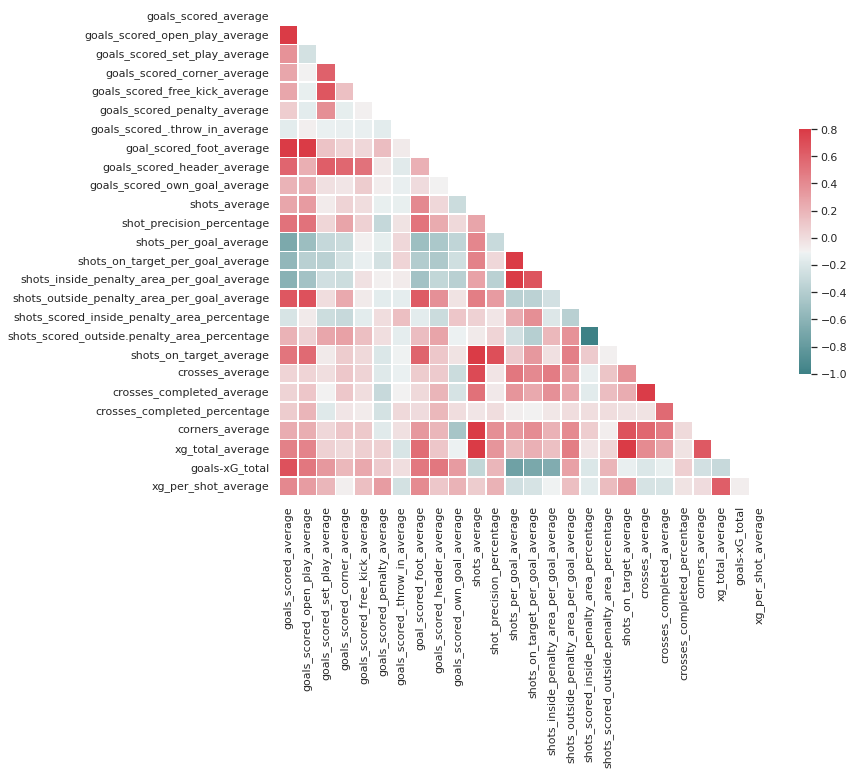

In [ ]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
R = corrcoef(df_feat)

# http://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(R, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(R, mask=mask, cmap=cmap, vmax=.8,
            square=True, xticklabels=names, yticklabels=names,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Mainly, most noticeable correlations between the features are:

1. `shots_per_goal`, `shots_on_target_per_goal`, `shots_inside_penalty_area_per_goal_average` with themselves (DP).

2. `shots_scored_inside_penalty_area_percentage` regarding `shots_scored_outside_penalty_area_percetage` (IP).

3. `shots_per_goal_average`, `shots_on_target_per_goal_average`, `shots_inside_penalty_area_per_goal_average` regarding `goals_scored_average`, `goals_scored_open_play_average`,`goals_scored_set_play_average`, `goals_scored_corner_average` (IP).

4. `shots_per_goal_average`, `shots_on_target_per_goal_average`, `shots_inside_penalty_area_per_goal_average` regarding `goal_scored_foot_average`, `goals_scored_header_average`, `goals_scored_own_goal_average` (IP).

5. `corners_average` regarding `goals_scored_own_goal_average` (DP).

6. `goals-xG_total` regarding `shots_per_goal_average`, `shots_on_target_per_goal_average`, `shots_inside_penalty_area_per_goal_average`. (IP)

7. `shots_average` regarding `corners_average`, `xg_total_average` (DP).

8. `goal_scored_average` regarding `goal_scored_foot_average` (DP).



Where IP means that it is an _Inversely Proportional_ correlation, and _Directly Proportional_ correlation.



The **first one** is logical, since both three are more descriptive evolution of the other ones. I mean, the `shots_on_target_per_goal` is directly proportional with the `shots_per_goal`, and the same with the `shots_inside_penalty_area_per_goal_average`. So, makes sense that it grows in the same way.



The **second one** is even obvious, since one is counting the opposite of the other.



The **third one** can be easily explained using toy formulas. The `shots_per_goal_average` can be expressed mathematically as $SxGoalAvg = \frac{`shots`}{`goals`}$. On the other side `goals_scored_average` can be expressed aproximately as $goalScoredAvg = λ \times `goals`$ where $λ$ means just a proportion to differentiate with the whole ammount of scored goals. 

If we analyze them, in the first one, the `goals` is dividing the expression, while in the second one, comes multiplying the expression, so, both are cancelled, i.e., they are inversely proportional.



The **fourth one** can be explained with the same reasoning as the previous one.



The **fifth one** might be a little tricky. We think that, defending a corner increases the probability of getting an own goal scored, since, there are more players in the area and so the goalkeeper has a reduced visibility and even the ball can accidentally bounce on a defending player. So, as this feature explains the attacking corners, we can infere that it is inversely correlated.



The **sixth one** is more or less the same case as the third and fourth ones, but the difference is that we count the expected goals instead of the scored goals.



The **seventh one** can be better explained splitted: first, the more corners you play, the most probability of getting a shot; secondly, the more the expected goals you get, the most probability of throwing shots.



Finally, the **eighth one**  we have the case of `goal_scored_average` and `goal_scored_foot_average`. Again, it makes sense, since both are counting the number of goals, so they are directly proportional.



As general conclussion of the similarity matrix analysis, we can see that, actually, it is feasible to reduce the number of features in this dataset.

We are now going to check those pairs of variables which their correlation is higher or equals to 0.8, either directly or inversely.

In [ ]:
cf = pd.DataFrame(R,index=names)
n = len(cf)
for i in range(n):
  for j in range(i):
    if cf[i][j] >= 0.8 or cf[i][j] <= -0.8:
      print(names[i] + ' - ' + names[j])

goals_scored_open_play_average - goals_scored_average
goal_scored_foot_average - goals_scored_average
goal_scored_foot_average - goals_scored_open_play_average
shots_on_target_per_goal_average - shots_per_goal_average
shots_inside_penalty_area_per_goal_average - shots_per_goal_average
shots_scored_outside.penalty_area_percentage - shots_scored_inside_penalty_area_percentage
shots_on_target_average - shots_average
corners_average - shots_average
xg_total_average - shots_average
xg_total_average - shots_on_target_average


# 4. Principal Component Analysis
We will use PCA analysis to know how the features are interrelated.

In [ ]:
#http://scikit-learn.org/stable/modules/preprocessing.html

min_max_scaler = preprocessing.StandardScaler()
features_norm = min_max_scaler.fit_transform(df_feat)

estimator = PCA (n_components = 3)
X_pca = estimator.fit_transform(features_norm)
print("Variance Ratio: ", estimator.explained_variance_ratio_) 

Variance Ratio:  [0.7599204  0.19412602 0.02477749]


The explained variance ratio per PC is acceptable. The X-axis represents more than 75% of the variability of the data set.

In [ ]:
#plotting orginal points with color related to label

fig = px.scatter(x=X_pca[:,0], y= X_pca[:,1])

for i in range(0,len(X_pca)):
     fig.add_annotation(x = X_pca[i,0], y = X_pca[i,1], text = names[i])
fig.show()

We can observe a big cluster at the left. Most of those variables are directly related to goals in some way (`goals-xG_total`, `goal_scored_average`, `xg_per_shot_average`, etc.). However, there are two features that at first glance don't seem related. The first one is `shot_precision_percentage`, although it makes sense that the higher the precision the more likely a shot is going to be a goal. The other one is `crosses_completed_percentage`, which also makes sense. If a center has been completed, the receiver is very likely to make a good shot and score.

Then we have four features a bit distanced from the cluster, which are: `crosses_completed_average`, `shots_on_target_per_goal_average`, `shots_on_target_average` and `corners_average`.

And finally, we have a total of five clear outliers which are very distanced from the rest. These are: `shots_inside_penalty_area_per_goal_average`, `shots_outside_penalty_area_per_goal_average`, `crosses_average`, `shots_average` and `shots_per_goal_average`.

# 5. Hierarchical Clustering

We will now use Hierarchical Clustering in order to better observe the relationships of similarities between features. Then, we can group them by similarity in order to reduce the dimensionality of the dataset.

We will use the results of the Principal Component Analysis.

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning:

sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3



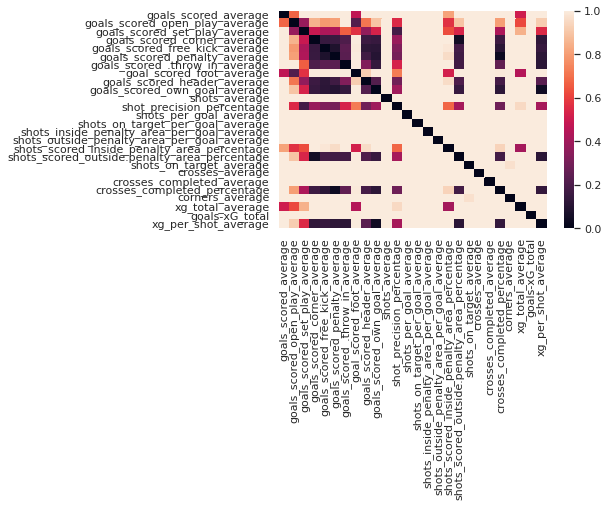

In [ ]:
#http://docs.scipy.org/doc/scipy/reference/cluster.html

dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matdist= dist.pairwise(X_pca)

ax = sns.heatmap(matdist,vmin=0, vmax=1, yticklabels = names, xticklabels = names)

We have a big group with a distance close to 0 between them, which are: `goals_scored_corner_average`, `goals_scored_free_kick_average`, `goals_scored_penalty_average`, `goals_scored_throw_in_average`, `goals_scored_header_average` and `goals_scored_own_goal_average`. This is alligned with what we saw in the scatterplot.

It is worth remarking that `shots_inside_penalty_area_per_goal_average` and `shots_outside_penalty_area_per_goal_average` have a distance of 1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



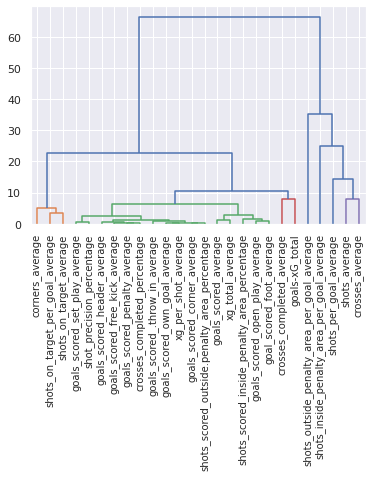

In [ ]:
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
clusters = cluster.hierarchy.linkage(matdist, method = 'complete')
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
cluster.hierarchy.dendrogram(clusters, color_threshold = 10, labels = names , leaf_rotation=90)
plt.show()

In [ ]:
cut = 10# !!!! ad-hoc
labels = cluster.hierarchy.fcluster(clusters, cut , criterion = 'distance')

labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 5, 1, 6, 7, 2, 2, 1, 4, 3, 2,
       1, 2, 3, 2], dtype=int32)

In [ ]:
#plotting orginal points with color related to label
fig = px.scatter(x=X_pca[:,0], y= X_pca[:,1], color = labels)

for i in range(0,len(X_pca)):
     fig.add_annotation(x = X_pca[i,0], y = X_pca[i,1], text = names[i])
fig.show()

Let's remember the results of the Correlation Analysis:

- `goals_scored_open_play_average` - `goals_scored_average`

- `goal_scored_foot_average` - `goals_scored_average`

- `goal_scored_foot_average` - `goals_scored_open_play_average`

- `shots_on_target_per_goal_average` - `shots_per_goal_average`

- `shots_inside_penalty_area_per_goal_average` - `shots_per_goal_average`

- `shots_scored_outside_penalty_area_percentage` - `shots_scored_inside_penalty_area_percentage`

- `shots_on_target_average` - `shots_average`

- `corners_average` - `shots_average`

- `xg_total_average` - `shots_average`

- `xg_total_average` - `shots_on_target_average`

From the hierarchical clustering, we can see that we got 6 clusters. There's a massive one where most of the features are grouped corresponding to color 2, and other two small ones corresponding to color 1 and 3. The other 3 clusters are outliers. Using the results from the Correlation Analysis, we determined that we are able to cut 5 features, which are:

- `goals_scored_open_play_average` and `goal_scored_foot_average`: From the group of three features correlated between each other, `goals_scored_average` was the most general out of them, so we considered that we lost less information removing `goals_scored_open_play_average` and `goal_scored_foot_average`
- `shots_on_target_per_goal_average`: Similarly to the previous point, `shots_per_goal_average` was the most general between the two of them.
- `shots_average`: If we look at the correlation matrix, compared with `corners_average`, it has more correlation with other features.
- `shots_outside_penalty_area_per_goal_average`: We tried to remove `shots_scored_outside_penalty_area_percentage`, but the results were not satisfying. So instead we decided to go with `shots_outside_penalty_area_per_goal_average` since it held the same information but expressed in other form.

So, at the end of this Feature Selection, we end up having 21 features which are:

* `goals_scored_average`
* `goals_scored_set_play_average`
* `goals_scored_corner_average`
* `goals_scored_free_kick_average`
* `goals_scored_penalty_average`
* `goals_scored_throw_in_average`
* `goals_scored_header_average`
* `goals_scored_own_goal_average`
* `shot_precision_percentage`
* `shots_per_goal_average`
* `shots_inside_penalty_area_per_goal_average`
* `shots_scored_inside_penalty_area_percentage`
* `shots_scored_outside_penalty_area_percentage`
* `shots_on_target_average`
* `crosses_average`
* `crosses_completed_average`
* `crosses_completed_percentage`
* `corners_average`
* `xg_total_average`
* `goals-xG_total`
* `xg_per_shot_average`